Bidirectional

In [ ]:
import tensorflow as tf
gpus =tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[0]

tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
!pip install hazm
#!pip install tensorflow-gpu

     |████████████████████████████████| 316 kB 8.7 MB/s 
     |████████████████████████████████| 233 kB 67.3 MB/s 
     |████████████████████████████████| 1.4 MB 65.4 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394488 sha256=0c1fc1e2acf800b98b9a736bc421faffca57e8ee900720a34ab2f9a3364c78f3
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154033 sha256=5b1f2b31b77f0b83a70a50dacba408bcc018c10cd2ed5e413e49d64123eb4354
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from hazm import *
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/digimag

/content/drive/MyDrive/digimag


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/digimag/digimag/train.csv', sep='\t', encoding="utf-8")
data

,Unnamed: 0,content,label,label_id
0,0,نمایش تبلیغ در لاک‌اسکرین تعدادی از گوشی‌های ه...,علم و تکنولوژی,3
1,1,شکست Justice League در باکس آفیس پس از بازخورد...,هنر و سینما,5
2,2,کلاسیک بینی؛ همه چیز در یک شب اتفاق افتاد فیلم...,هنر و سینما,5
3,3,اپل دوباره سراغ رنده رفته چراکه آپگرید کردن سط...,علم و تکنولوژی,3
4,4,بررسی جزء به جزء بهترین بخش Ori and the Blind ...,بازی ویدیویی,0
...,...,...,...,...
6891,6891,چند ساعت خواب برای بدن شما مفید است؟ شایع است ...,سلامت و زیبایی,2
6892,6892,فیلم مگامن ساخته می‌شود شرکت بازی‌سازی کپ‌کام ...,بازی ویدیویی,0
6893,6893,تعداد حملات بدافزاری به سیستم‌ عامل مکینتاش بر...,علم و تکنولوژی,3
6894,6894,چطور از مبتلا شدن به آنفولانزا پیشگیری کنیم؟ (...,سلامت و زیبایی,2


In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/digimag/digimag/test.csv', sep='\t', encoding="utf-8")
testdata

,content,true_label_id,prediction label
0,با این ۵ صبحانه رژیمی لاغر شوید صبحانه همیشه ب...,2,سلامت و زیبایی
1,نمایشگر گوشی تاشونده ال‌جی مانند بروشور باز و ...,3,علم و تکنولوژی
2,چرا برخی سلبریتی‌های هالیوودی از شبکه‌های اجتم...,5,هنر و سینما
3,گوگل استیدیا؛ آینده‌ی صنعت بازی یا محکوم به شک...,0,بازی ویدیویی
4,ویژگی جذاب گلکسی Z Flip به زودی به گوشی‌های ان...,3,علم و تکنولوژی
...,...,...,...
847,Death Stranding پر از میان‌پرده‌های طولانی است...,0,بازی ویدیویی
848,حالت نیو گیم پلاس به اسپایدرمن اضافه می‌شود چن...,0,بازی ویدیویی
849,بوکوفسکی؛ ملک‌الشعرای فرودستان آمریکا چارلز بو...,6,کتاب و ادبیات
850,چگونه مثل جف بزوس هک نشویم؛ ۵ توصیه امنیتی برا...,3,علم و تکنولوژی


In [ ]:
sentence_train = data['content']
label_train = data['label_id']

print('Number of training sentence: ', sentence_train.shape)
print('Number of training label: ', label_train.shape)

Number of training sentence:  (6896,)
Number of training label:  (6896,)


In [ ]:
data.shape, testdata.shape

((6896, 4), (852, 3))

In [ ]:
data.label_id.value_counts()

3    2245
0    1593
5    1350
2    1304
6     206
1     101
4      97
Name: label_id, dtype: int64

In [ ]:
data.isnull().sum()

Unnamed: 0    0
content       0
label         0
label_id      0
dtype: int64

In [ ]:
testdata.isnull().sum()

content             0
true_label_id       0
prediction label    0
dtype: int64

In [ ]:
from collections import Counter
cnt = Counter(label_train)
cnt = dict(cnt)
print(cnt)

{3: 2245, 5: 1350, 0: 1593, 6: 206, 2: 1304, 4: 97, 1: 101}


In [ ]:
sentence_train = np.asarray(sentence_train)
label_train = np.asarray(label_train)

categorical_label_train = to_categorical(label_train, 7)
categorical_label_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import re
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()

def clean_data(doc):
    doc = normalizer.normalize(doc) 
    tokenized = word_tokenize(doc)  
    tokens = []
    for token in tokenized:      
      token = re.sub("[،:.,;()/+]", " ", token) 
      token = re.sub(r"\!+","!", token)
      token = re.sub(r"\؟+","؟", token)
      token = re.sub(r"\u200c", " ", token)
      token = token.lower()
      token = re.sub('<[^>]*>', '', token)
      token = re.sub('\S*@\S*\s?', '', token)
      token = re.sub('https?://[A-Za-z0-9]','',token)
      token = re.sub('[^a-zA-Z]',' ',token)
      token = re.sub(r"\'s", "", token)
      token = re.sub(r"\'ve", "", token)
      token = re.sub(r"n\'t", "", token)
      token = re.sub(r"\'re", "", token)
      token = re.sub(r"\'d", "", token)
      token = re.sub(r"\'11", "", token)
      token = re.sub(r"'", "", token)
      token = re.sub(r"\s{2,}", "", token)
      tokens.append(token)

    tokens = [w for w in tokens if not len(w) <= 1]  
    tokens = [w for w in tokens if not w.isdigit()] 
    tokens = [lemmatizer.lemmatize(w) for w in tokens] 
    tokens = [stemmer.stem(w) for w in tokens] 
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
train_docs = np.empty_like(sentence_train)
for index, document in enumerate(sentence_train):
  train_docs[index] = clean_data(document)

In [ ]:
num_words = 6896
# Create the tokenizer
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(encoded_docs)

[[1972, 94, 32, 63, 2459, 4011, 1, 17], [393, 213, 393, 213, 393, 213, 689, 574, 22, 3, 1065, 855, 764, 171, 952, 393, 213, 393, 213, 393, 213, 393, 213, 393, 213, 689, 575, 856, 1374, 4, 232, 1200, 169, 1, 4012, 1066, 1, 34, 507, 4, 2179, 901, 1375, 604, 5077, 5078, 5079, 5080, 3282, 78], [93], [298, 150, 2, 8, 2835, 2836, 21, 2836, 131, 714, 2836, 622, 622, 5081, 5081, 622, 622, 5082, 343, 1201, 1006, 311, 138, 1271, 38, 42, 332, 2180, 214, 8, 605, 138, 265, 1202, 138, 18, 19, 18, 138, 101], [1490, 35, 1, 2181, 902, 16, 454, 4, 729, 1490, 35, 1, 2181, 902, 1, 1780, 39, 2182, 508, 1973, 4013, 1628, 1491, 538, 151, 173, 164, 89, 1629, 493, 1203, 730, 5083, 4, 68, 2460, 265, 1781, 825, 152, 1490, 35, 1, 799, 3, 1, 3283], [], [], [2183, 903], [1630, 5084], [181, 181, 181, 181, 181], [1, 1782, 1128, 1, 1782, 1128, 1, 1782, 1128, 1, 1782, 1128, 731, 3284, 857, 3284, 2461, 1376], [2462, 2462, 2462, 2462, 2462, 2462], [48, 48, 48, 48, 215, 48, 215, 48, 5085, 14, 48, 48, 48, 48, 48, 95, 48, 1

In [ ]:
max_length = max([len(s.split()) for s in train_docs])
max_length

1264

In [ ]:
x_train_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
x_train_padded[1]

array([393, 213, 393, ...,   0,   0,   0], dtype=int32)

In [ ]:
vocab_size = len(tokenizer.word_index)
embed_size = 300

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D()) 
model.add(Dense(1024))
model.add(Dropout(0.25)) 
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax')) 

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy"])
model.summary()
batch_size = 64
epochs = 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1264, 300)         4158600   
_________________________________________________________________
bidirectional (Bidirectional (None, 1264, 256)         439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1264, 128)         164352    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

In [ ]:
history = model.fit(x_train_padded, categorical_label_train,
                             batch_size=batch_size, epochs=epochs,
                             shuffle=True)

Epoch 1/20
108/108 [==============================] - 38s 306ms/step - loss: 0.3655 - categorical_accuracy: 0.8677
Epoch 2/20
108/108 [==============================] - 33s 305ms/step - loss: 0.3519 - categorical_accuracy: 0.8702
Epoch 3/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3389 - categorical_accuracy: 0.8750
Epoch 4/20
108/108 [==============================] - 33s 306ms/step - loss: 0.3465 - categorical_accuracy: 0.8767
Epoch 5/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3271 - categorical_accuracy: 0.8754
Epoch 6/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3300 - categorical_accuracy: 0.8743
Epoch 7/20
108/108 [==============================] - 33s 306ms/step - loss: 0.3313 - categorical_accuracy: 0.8753
Epoch 8/20
108/108 [==============================] - 33s 308ms/step - loss: 0.3540 - categorical_accuracy: 0.8733
Epoch 9/20
108/108 [==============================] - 33s 307ms/step - loss: 0.3

In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/digimag/digimag/test.csv', sep='\t', encoding="utf-8")

x_test = testdata['content']
y_test = testdata['true_label_id']

In [ ]:
print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (852,)
Number of testing label:  (852,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = model.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 4s 99ms/step - loss: 1.3802 - categorical_accuracy: 0.7465
Test Accuracy: 74.647886


LSTM

In [ ]:
vocab_size = len(tokenizer.word_index)

model_blstm = Sequential()

model_blstm.add(Embedding(vocab_size, 300, input_length=max_length))

model_blstm.add(GlobalMaxPool1D())
model_blstm.add(Dropout(0.25))
model_blstm.add(Dense(300, activation="relu"))
model_blstm.add(Dropout(0.2))
model_blstm.add(Dense(7, activation='softmax'))

model_blstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["categorical_accuracy"])

model_blstm.summary()
batch_size_blstm = 64
epochs_blstm = 12

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1264, 300)         4158600   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 300)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 2107      
Total params: 4,251,007
Trainable params: 4,251,007
Non-trainable params: 0
____________________________________________

In [ ]:
hist_blstm = model_blstm.fit(x_train_padded, categorical_label_train,
                             batch_size=batch_size_blstm, epochs=epochs_blstm,
                             shuffle=True)

Epoch 1/12
108/108 [==============================] - 9s 82ms/step - loss: 1.3095 - categorical_accuracy: 0.5068
Epoch 2/12
108/108 [==============================] - 9s 82ms/step - loss: 0.7621 - categorical_accuracy: 0.7542
Epoch 3/12
108/108 [==============================] - 9s 81ms/step - loss: 0.5468 - categorical_accuracy: 0.8247
Epoch 4/12
108/108 [==============================] - 9s 80ms/step - loss: 0.4501 - categorical_accuracy: 0.8447
Epoch 5/12
108/108 [==============================] - 9s 80ms/step - loss: 0.3942 - categorical_accuracy: 0.8573
Epoch 6/12
108/108 [==============================] - 9s 80ms/step - loss: 0.3649 - categorical_accuracy: 0.8677
Epoch 7/12
108/108 [==============================] - 9s 81ms/step - loss: 0.3434 - categorical_accuracy: 0.8753
Epoch 8/12
108/108 [==============================] - 9s 81ms/step - loss: 0.3258 - categorical_accuracy: 0.8821
Epoch 9/12
108/108 [==============================] - 9s 83ms/step - loss: 0.3199 - categorical_

In [ ]:
accr = model.evaluate(x_train_padded)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

216/216 [==============================] - 60s 278ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test set
  Loss: 0.000
  Accuracy: 0.000


In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/digimag/digimag/test.csv', sep='\t', encoding="utf-8")

x_test = testdata['content']
y_test = testdata['true_label_id']

print('Number of testing sentence: ', x_test.shape)
print('Number of testing label: ', y_test.shape)

Number of testing sentence:  (852,)
Number of testing label:  (852,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = model.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 4s 99ms/step - loss: 1.3802 - categorical_accuracy: 0.7465
Test Accuracy: 74.647886


GRU

In [ ]:
vocab_size = len(tokenizer.word_index)
embed_size = 300

In [ ]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

mode = Sequential()
mode.add(Embedding(vocab_size, embed_size, input_length=max_length))
mode.add(GRU(50, return_sequences=True))
mode.add(Dropout(0.2))
mode.add(GRU(100,return_sequences=False))
mode.add(Dropout(0.2))
mode.add(Dense(1, activation = "linear"))

mode.compile(loss="mean_squared_error",optimizer="rmsprop",metrics=['accuracy'])

history = mode.fit(x_train_padded,categorical_label_train,epochs= 12,batch_size=64,validation_split=0.2)

Epoch 1/12
87/87 [==============================] - 18s 163ms/step - loss: 0.1259 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 2/12
87/87 [==============================] - 13s 152ms/step - loss: 0.1227 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 3/12
87/87 [==============================] - 13s 153ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 4/12
87/87 [==============================] - 13s 153ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 5/12
87/87 [==============================] - 13s 150ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 6/12
87/87 [==============================] - 13s 149ms/step - loss: 0.1226 - accuracy: 0.8571 - val_loss: 0.1225 - val_accuracy: 0.8571
Epoch 7/12
87/87 [==============================] - 13s 149ms/step - loss: 0.1225 - accuracy: 0.8571 - val_loss: 0.1224 - val_accuracy: 0.8571

In [ ]:
train_loss, train_accuracy = mode.evaluate(x_train_padded, categorical_label_train, batch_size=64)
train_accuracy

108/108 [==============================] - 7s 62ms/step - loss: 0.1225 - accuracy: 0.8571


0.8571420907974243

In [ ]:
testdata=pd.read_csv('/content/drive/MyDrive/digimag/digimag/test.csv', sep='\t', encoding="utf-8")

sentence_test = data['content']
label_test = data['label_id']

print('Number of testing sentence: ', sentence_test.shape)
print('Number of testing label: ', label_test.shape)

Number of testing sentence:  (6896,)
Number of testing label:  (6896,)


In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# Applying preprocessing step to test data
test_docs = np.empty_like(x_test)
for index, document in enumerate(x_test):
  test_docs[index] = clean_data(document)

encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_test_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

categorical_y_test = to_categorical(y_test, 7)

loss, acc = mode.evaluate(x_test_padded, categorical_y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

27/27 [==============================] - 1s 49ms/step - loss: 0.1225 - accuracy: 0.8571
Test Accuracy: 85.714293


In [ ]:
y_pred = mode.predict_classes(x_test_padded)

In [ ]:
content = []
true_label_id = []
pred_label_id = []
بازی_ویدیویی = 0
راهنمای_خرید = 0
سلامت_و_زیبایی = 0
علم_و_تکنولوژی = 0
عمومی = 0
هنر_و_سینما = 0
کتاب_و_ادبیات = 0
for i in range(len(y_pred)):
  content.append(x_test[i])
  true_label_id.append(y_test[i])

  if y_pred[i] == 0:
    بازی_ویدیویی +=1
    pred_label_id.append("بازی ویدیویی")
  elif y_pred[i] == 1:
    راهنمای_خرید +=1
    pred_label_id.append("راهنمای خرید")
  elif y_pred[i] == 2:
    سلامت_و_زیبایی +=1
    pred_label_id.append("سلامت و زیبایی")
  if y_pred[i] == 3:
    علم_و_تکنولوژی +=1
    pred_label_id.append("علم و تکنولوژی")
  elif y_pred[i] == 4:
    عمومی +=1
    pred_label_id.append("عمومی")
  elif y_pred[i] == 5:
    هنر_و_سینما +=1
    pred_label_id.append("هنر و سینما")
  elif y_pred[i] == 6:
    کتاب_و_ادبیات +=1
    pred_label_id.append("کتاب و ادبیات")


print("عمومی: " , (عمومی/27)*100)
print("راهنمای_خرید: " , (راهنمای_خرید/27)*100)
print("بازی_ویدیویی: " , (بازی_ویدیویی/27)*100)
print("سلامت_و_زیبایی: " , (سلامت_و_زیبایی/27)*100)
print("علم_و_تکنولوژی: " , (علم_و_تکنولوژی/27)*100)
print("هنر_و_سینما: " , (هنر_و_سینما/27)*100)
print("کتاب_و_ادبیات: " , (کتاب_و_ادبیات/27)*100)

عمومی:  0.0
راهنمای_خرید:  0.0
بازی_ویدیویی:  0.0
سلامت_و_زیبایی:  0.0
علم_و_تکنولوژی:  3155.5555555555557
هنر_و_سینما:  0.0
کتاب_و_ادبیات:  0.0


<Figure size 432x288 with 0 Axes>

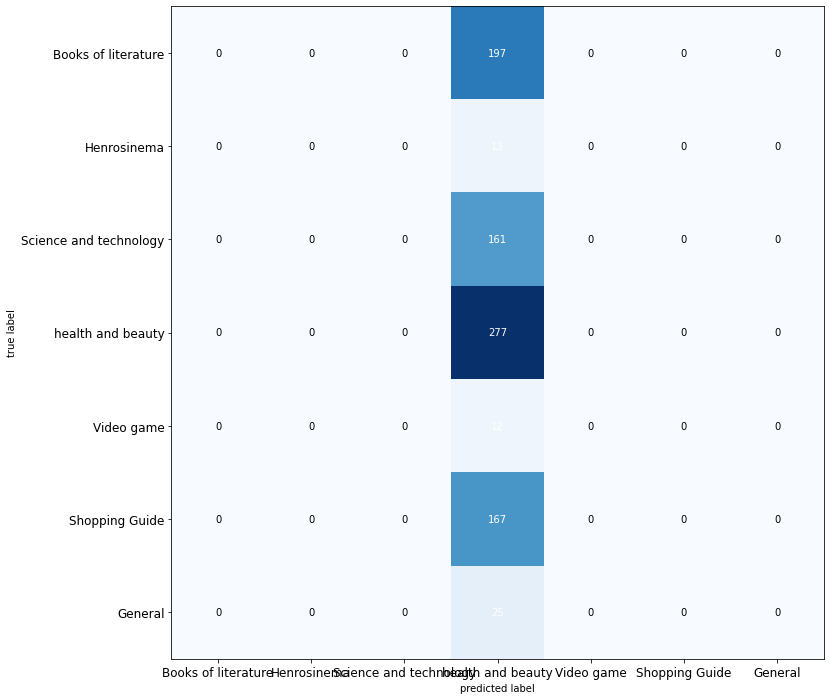

In [ ]:
dataFrame = pd.DataFrame({"content":content, "true_label_id":true_label_id, "prediction label":pred_label_id})

dataFrame.to_csv('/content/drive/MyDrive/digimag/digimag/train2.csv', sep='\t', index=False)

label = ['Books of literature', 'Henrosinema', 'Science and technology', 'health and beauty', 'Video game', 'Shopping Guide', 'General']
y_pred = [np.argmax(i) for i in mode.predict(x_test_padded)]
cm  = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(7), label, fontsize=12)
plt.yticks(range(7), label, fontsize=12)
plt.show()

In [ ]:
def modelDemo(news_content):

  #News Label
  label = ['کتابهای ادبیات', 'هنروسینما', 'علم و تکنولوژی', 'سلامتی و زیبایی', 'بازی ویدیویی', 'راهنمای خرید', 'عمومی']
  test_seq = pad_sequences(tokenizer.texts_to_sequences(news_content), maxlen=max_length)
  y_pred = [label[np.argmax(i)] for i in mode.predict(test_seq)]

  for news, label in zip(news_content, y_pred):
      print('{} - {}'.format(colored(news, 'green'), colored(label, 'red')))

from termcolor import colored

modelDemo(['امروز هم با یکی دیگر از مطالب سریالی ماشین‌های سینمایی همراه شما هستیم.'])

امروز هم با یکی دیگر از مطالب سریالی ماشین‌های سینمایی همراه شما هستیم. - سلامتی و زیبایی


In [ ]:
modelDemo(['مینی در سال ۲۰۱۸ مینی امروز با چهره جدید و به‌روز شده در بازار جهانی عرضه می‌شود. جدیدترین مدل‌ این خودرو هم‌اکنون توسط شرکت پرشیا خودرو، نماینده محصولات ب‌ام‌و در ایران وارد شده و به زودی به فروش می‌رود.'])

مینی در سال ۲۰۱۸ مینی امروز با چهره جدید و به‌روز شده در بازار جهانی عرضه می‌شود. جدیدترین مدل‌ این خودرو هم‌اکنون توسط شرکت پرشیا خودرو، نماینده محصولات ب‌ام‌و در ایران وارد شده و به زودی به فروش می‌رود. - سلامتی و زیبایی
